# EDSA Sendy Logistics Challenge

## Contents

 1. Required Imports & Libraries
 2. Import the Data
 3. Data Cleaning & Formatting
 4. Exploratory Data Analysis
 5. Feature Engineering and selection
 6. Building & Evaluating Models
 7. Training the Model and making a prediction
 8. Generating a Submission file for ZINDI
 9. References

### 1. Required Imports & Libraries

In [ ]:
## Required Libraries & imports for the model

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV 
from sklearn.model_selection import cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error

from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

import xgboost as xgb
import lightgbm as lgb

sns.set(style='white', context='notebook', palette='deep')

### 2. Import the Data

In [ ]:
##Importing Training Data CSV file
train_url = 'https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Train_Zindi.csv'
train_df = pd.read_csv(train_url)

##Importing Test Data
test_url = 'https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Test_Zindi.csv'
test_df = pd.read_csv(test_url)

##Importing Riders Data CSV file
riders_url = 'https://raw.githubusercontent.com/AksharJ47/regression-predict-api-template/master/utils/data/Riders_Zindi.csv'
riders_df = pd.read_csv(riders_url)

print(train_df.shape, test_df.shape, riders_df.shape)
train_df.head()

### 3. Data Cleaning & Formatting

In [ ]:
#Drop data not available in test, Pickup Time + label = Arrival times

train_df = train_df.drop(['Arrival at Destination - Day of Month', 'Arrival at Destination - Weekday (Mo = 1)',
                          'Arrival at Destination - Time'], axis=1)

In [ ]:
#Combine train & test to create a full df

train_end = train_df.shape[0]
test_df['Time from Pickup to Arrival'] = [np.nan]* test_df.shape[0]
full_df = pd.concat([train_df, test_df], axis=0, ignore_index=True)
full_riders_df = pd.merge(full_df, riders_df, how='left', left_on='Rider Id', right_on='Rider Id', left_index=True)

train_df.shape, test_df.shape, full_df.shape, full_riders_df.shape

In [ ]:
# Check features and their data types 
# From here we see that there are missing values in Temperature and Precipitation
full_riders_df.info()

In [ ]:
# Shorten Column Names, remove whitespace & Standardise to make them easier to work with

feature_names = {"Order No": "Order_No", "User Id": "User_Id", "Vehicle Type": "Vehicle_Type",
    "Personal or Business": "Personal_Business", "Placement - Day of Month": "Pla_Mon",
    "Placement - Weekday (Mo = 1)": "Pla_Weekday", "Placement - Time": "Pla_Time", 
    "Confirmation - Day of Month":"Con_Day_Mon", "Confirmation - Weekday (Mo = 1)": "Con_Weekday","Confirmation - Time": "Con_Time", 
    "Arrival at Pickup - Day of Month": "Arr_Pic_Mon", "Arrival at Pickup - Weekday (Mo = 1)": "Arr_Pic_Weekday", 
                "Arrival at Pickup - Time": "Arr_Pic_Time", "Platform Type": "Platform_Type",
     "Pickup - Day of Month": "Pickup_Mon", "Pickup - Weekday (Mo = 1)": "Pickup_Weekday",           
    "Pickup - Time": "Pickup_Time",  "Distance (KM)": "Distance(km)",
    "Precipitation in millimeters": "Precipitation(mm)", "Pickup Lat": "Pickup_Lat", "Pickup Long": "Pickup_Lon", 
    "Destination Lat": "Destination_Lat", "Destination Long":"Destination_Lon", "Rider Id": "Rider_Id",
                            "Time from Pickup to Arrival": "Time_Pic_Arr"
                           }

renamed_df = full_riders_df.rename(columns=feature_names)
renamed_df.columns

In [ ]:
## Convert time to Seconds after midnight 

def time_conv(input_df):
    input_df_1 = input_df.copy()
    def timetosecs(x):
        if len(x) == 10:
            if x[-2:] == 'AM':
                x = (float(x[0])*3600) + (float(x[2:4])*60) + float(x[5:7])
            else:
                x = (float(x[0])*43200) + (float(x[2:4])*60) + float(x[5:7])
        else:
            if x[-2:] == 'AM':
                x = (float(x[0:2])*3600) + (float(x[3:5])*60) + float(x[6:8])
            else:
                x = (float(x[0:2])*43200) + (float(x[3:5])*60) + float(x[6:8])
        return x
    
    input_df_1['Pla_Time'] = input_df_1['Pla_Time'].apply(timetosecs)
    input_df_1['Con_Time'] = input_df_1['Con_Time'].apply(timetosecs)
    input_df_1['Arr_Pic_Time'] = input_df_1['Arr_Pic_Time'].apply(timetosecs)
    input_df_1['Pickup_Time'] = input_df_1['Pickup_Time'].apply(timetosecs)
    
    return input_df_1

time_conv_df = time_conv(renamed_df)

In [ ]:
## Add Columns for time differences

def time_diffs(input_df):
    time_diffs_df = input_df.copy()
    time_diffs_df['Conf_Pla_dif'] = time_diffs_df['Con_Time'] - time_diffs_df['Pla_Time']
    time_diffs_df['Arr_Con_dif'] = time_diffs_df['Arr_Pic_Time'] - time_diffs_df['Con_Time']
    time_diffs_df['Pic_Arr_dif'] = time_diffs_df['Pickup_Time'] - time_diffs_df['Arr_Pic_Time']
    
    return time_diffs_df

In [ ]:
time_conv_df = time_diffs(time_conv_df)

### 4. Exploratory Data Analysis (EDA)

### 5.  Feature Engineering & Selection

In [ ]:
# Add Rider Experience based on Age Column - Low - Medium - High

time_conv_df['Rider_Exp'] = pd.qcut(time_conv_df['Age'], q=[0, .25, .75, 1], labels=['low', 'medium', 'high'])

In [ ]:
# Filling Missing Values for Temperature and Precipitation - used the Mean

time_conv_df['Temperature'] = time_conv_df['Temperature'].fillna(time_conv_df['Temperature'].mean())
time_conv_df['Precipitation(mm)'].fillna(time_conv_df['Precipitation(mm)'].mean(), inplace=True)


In [ ]:
## Create Temperature band Column - 3 categories - low, mid, high

time_conv_df['Temp_Band'] = pd.qcut(time_conv_df['Temperature'], q=[0, .25, .75, 1], labels=['low', 'medium', 'high'])

In [ ]:
#Manhattan distance
def manhattan_distance(lat1, lng1, lat2, lng2):
    a = np.abs(lat2 -lat1)
    b = np.abs(lng1 - lng2)
    return a + b


In [ ]:
##Add Manhattan to DF
def added_manhattan(input_df):
    input_df_1 = input_df.copy()
    input_df_1['distance_manhattan'] = manhattan_distance(input_df_1['Pickup_Lat'].values,
                                                          input_df_1['Pickup_Lon'].values,
                                                          input_df_1['Destination_Lat'].values,
                                                          input_df_1['Destination_Lon'].values)
    return input_df_1

time_conv_df = added_manhattan(time_conv_df)

## Add Reference for this

In [ ]:
#Haversine distance
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

## Add Reference for this

In [ ]:
##Add Haversine Distance to DF

def add_haversine(input_df):
    input_df_1 = input_df.copy()
    input_df_1['distance_haversine'] = haversine_array(input_df_1['Pickup_Lat'].values,
                                                       input_df_1['Pickup_Lon'].values,
                                                       input_df_1['Destination_Lat'].values,
                                                       input_df_1['Destination_Lon'].values)
    return input_df_1

time_conv_df = add_haversine(time_conv_df)

In [ ]:
# This is to check if there is any difference between the columns with Days of Month or Weekday of Month

month_cols = [col for col in time_conv_df.columns if col.endswith('Mon')]
weekday_cols = [col for col in time_conv_df.columns if col.endswith('Weekday')]

count = 0
instances_of_different_days = [];
for i, row in time_conv_df.iterrows():
    if len(set(row[month_cols].values)) > 1:
        print(count+1, end='\r')
        count = count + 1
        instances_of_different_days.append(list(row[month_cols].values))
instances_of_different_days

In [ ]:
# Drop columns based on:
   #Days of Month or Weekday of Month are the same except for 2 rows. The delivery service is same day
   #All Vehicle types are Bikes, Vehicle Type is not necessary.

time_conv_df['Day_of_Month'] = time_conv_df[month_cols[0]]
time_conv_df['Day_of_Week'] = time_conv_df[weekday_cols[0]]

time_conv_df.drop(month_cols+weekday_cols, axis=1, inplace=True)
time_conv_df.drop('Vehicle_Type', axis=1, inplace=True)

time_conv_df.head(3)


In [ ]:
#Convert Personal_Business Temp_Band using LabelEncoding

le = LabelEncoder()
le.fit(time_conv_df['Personal_Business'])
time_conv_df['Personal_Business'] = le.transform(time_conv_df['Personal_Business'])
time_conv_df['Personal_Business'][:2]


In [ ]:
# Rider_Exp convert Label Encoding

le.fit(time_conv_df['Rider_Exp'])
time_conv_df['Rider_Exp'] = le.transform(time_conv_df['Rider_Exp'])
time_conv_df['Rider_Exp'][:2]

In [ ]:
## Convert Temp_Band using LabelEncoding

le.fit(time_conv_df['Temp_Band'])
time_conv_df['Temp_Band'] = le.transform(time_conv_df['Temp_Band'])
time_conv_df['Temp_Band'][:2]

In [ ]:
## This function splits Columns into Data types - this makes it easier to select & plot numeric features
## against the Target Variable

numeric_cols = []
object_cols = []
time_cols = []
for k, v in time_conv_df.dtypes.items():
    if (v != object):
        if (k != "Time_Pic_Arr"):
            numeric_cols.append(k)
    elif k.endswith("Time"):
        time_cols.append(k)
    else:
        object_cols.append(k)
time_conv_df[numeric_cols].head(3) 

In [226]:
## Feature Selection & Dropping of the Target Variable

features = numeric_cols 

data_df = time_conv_df[features]

y = time_conv_df[:train_end]['Time_Pic_Arr']
train = data_df[:train_end]
test = data_df[train_end:]

test.head()

,Platform_Type,Personal_Business,Pla_Time,Con_Time,Arr_Pic_Time,Pickup_Time,Distance(km),Temperature,Precipitation(mm),Pickup_Lat,...,No_of_Ratings,Conf_Pla_dif,Arr_Con_dif,Pic_Arr_dif,Rider_Exp,Temp_Band,distance_manhattan,distance_haversine,Day_of_Month,Day_of_Week
183,3,0,175450.0,175469.0,175984.0,216407.0,8,23.255689,7.573502,-1.333275,...,171,19.0,515.0,40423.0,0,2,0.076451,6.220125,27,3
826,3,0,521855.0,521957.0,44427.0,44737.0,5,23.255689,7.573502,-1.272639,...,45,102.0,-477530.0,310.0,1,2,0.033551,3.280436,17,5
650,3,0,40094.0,41105.0,41600.0,43074.0,5,22.800000,7.573502,-1.290894,...,67,1011.0,495.0,1474.0,1,2,0.042714,3.535344,27,4
561,3,0,46295.0,46407.0,86561.0,87412.0,5,24.500000,7.573502,-1.290503,...,44,112.0,40154.0,851.0,2,2,0.031867,2.550774,17,1
203,3,0,41428.0,41685.0,42439.0,42964.0,6,24.400000,7.573502,-1.281081,...,1010,257.0,754.0,525.0,2,2,0.036875,2.960588,11,2


### 6. Building & Evaluating Models

In [227]:
## Splitting the Data into Train & Test sets, ratio of 80:20 & inspecting the shape

X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, shuffle=True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(16960, 26) (4241, 26) (16960,) (4241,)


### K-fold Cross Validation

##### The general procedure is as follows:

Shuffle the dataset randomly.
Split the dataset into k groups
For each unique group:
Take the group as a hold out or test data set
Take the remaining groups as a training data set
Fit a model on the training set and evaluate it on the test set
Retain the evaluation score and discard the model
Summarize the skill of the model using the sample of model evaluation scores
Importantly, each observation in the data sample is assigned to an individual group and stays in that group for the duration of the procedure. This means that each sample is given the opportunity to be used in the hold out set 1 time and used to train the model k-1 times.

In [228]:
##  k-fold cross-validation procedure for estimating the skill of machine learning models

rs = 3
kfold = KFold(n_splits=10, random_state=rs, shuffle=True)

regressors = []
regressors.append(SVR())
regressors.append(GradientBoostingRegressor(random_state=rs))
regressors.append(ExtraTreesRegressor(n_estimators=rs))
regressors.append(RandomForestRegressor(random_state=rs))
regressors.append(xgb.XGBRegressor(random_state=rs, objective="reg:squarederror"))
regressors.append(lgb.LGBMRegressor(random_state=rs))

cv_results = []
for regressor in regressors:     #scores to be minimised are negated (neg)
    cv_results.append(np.sqrt(abs(cross_val_score(regressor, X_train, y=y_train, scoring='neg_mean_squared_error', cv=kfold))))

cv_means = []
cv_stds = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_stds.append(cv_result.std())
    
cv_res = pd.DataFrame({ 
    "Algorithm": ["SVR", "GBR", "EXR", "RFR", "XGBR", "LGBM"],
    "CrossValMeans": cv_means, "CrossValErrors": cv_stds
                       })
cv_res = cv_res.sort_values("CrossValMeans", ascending=True)
print(cv_res)

  Algorithm  CrossValMeans  CrossValErrors
5      LGBM     745.025632       14.476620
1       GBR     758.421659       15.869290
4      XGBR     767.805775       18.467528
3       RFR     811.472917       17.313583
2       EXR     907.140659       17.551456
0       SVR    1003.691213       14.268424


##### Based on the above LGBM

In [229]:
params = {
    'n_estimators':[75], # [75, 95],
    'num_leaves': [15], #[12,15, 17],
    'reg_alpha': [0.02], #[0.02, 0.05],
    'min_data_in_leaf': [300],  #[250, 280, 300]
    'learning_rate': [0.1], #[0.05, 0.1, 0.25],
    'objective': ['regression'] #['regression', None]
    }

lsearch = GridSearchCV(estimator = lgb.LGBMRegressor(random_state=rs), cv=kfold,scoring='neg_mean_squared_error', param_grid=params)
lgbm = lsearch.fit(X_train, y_train)

l_params = lgbm.best_params_
l_score = np.sqrt(abs(lgbm.best_score_))
print(lgbm.best_params_, np.sqrt(abs(lgbm.best_score_)))


{'learning_rate': 0.1, 'min_data_in_leaf': 300, 'n_estimators': 75, 'num_leaves': 15, 'objective': 'regression', 'reg_alpha': 0.02} 749.6880592875951


In [230]:
RFC = RandomForestRegressor(random_state=rs)
rf_param = {"max_depth":[None], "max_features":[3], "min_samples_split":[10],
           "min_samples_leaf": [3], "n_estimators":[300]}
rsearch = GridSearchCV(RFC, cv=kfold, scoring='neg_mean_squared_error',param_grid=rf_param)
rfm = rsearch.fit(X_train, y_train)

r_score = np.sqrt(abs(rfm.best_score_))
r_params = rfm.best_params_
print(r_score, r_params)

760.0116106684333 {'max_depth': None, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 300}


#### Plotting the Learning curves

In [231]:
def plot_learning_curve(estimator, title, X, y, ylim=None, n_jobs=-1, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generating a plot of test and training learning curve"""
    plt.figure()
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='neg_mean_squared_error', shuffle=True)
    
    #scores - 5 runs, each with 10 fold
    train_scores_mean = -np.mean(train_scores, axis=1) #5 means (each size)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r' )
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    
    plt.legend(loc='best')
    return plt


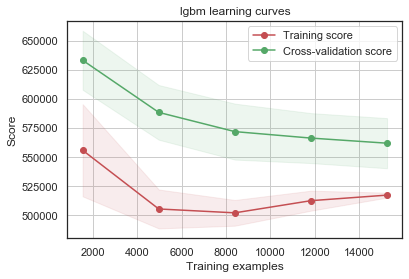

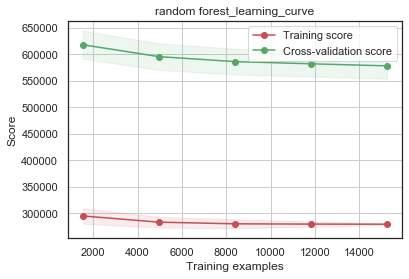

In [232]:
#Learning Curves

g = plot_learning_curve(lgbm.best_estimator_, "lgbm learning curves", X_train, y_train, cv=kfold)
g = plot_learning_curve(rfm.best_estimator_, "random forest_learning_curve", X_train, y_train, cv=kfold)

#lgbm: mse error comment here
#rf: mse error comment here

##### From the above learning curves we can see that the LGBM curve seems to continue to decrease, at a decreasing rate, as the number of samples increases. The RFC however, seems to have levelled off just above 8000 samples.

#### We can now plot the Feature Importance of the two models, which will enable us to fine tune them further

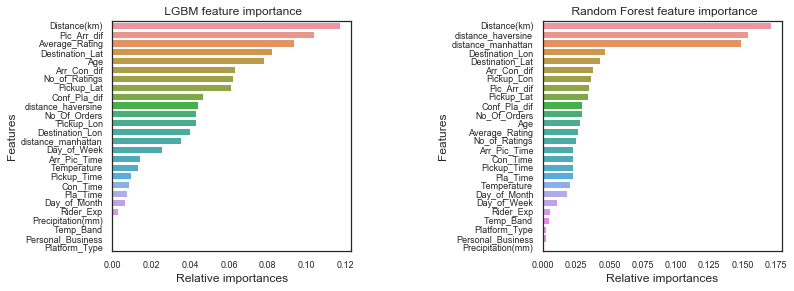

In [233]:
vals = lgbm.best_estimator_.feature_importances_
l_importance = np.array([ val/sum(vals) for val in vals ])
r_importance  = rfm.best_estimator_.feature_importances_
feats = np.array(features)

fig,axes = plt.subplots(1,2, figsize=(12, 8))
plt.subplots_adjust(top=0.6, bottom=0.2, hspace=.6, wspace=0.8)

indices = np.argsort(l_importance)[::-1]
g = sns.barplot(y=feats[indices], x=l_importance[indices], orient='h', ax=axes[0])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" LGBM feature importance")

index = np.argsort(r_importance)[::-1]
g = sns.barplot(y=feats[index], x=r_importance[index], orient='h', ax=axes[1])
g.set_xlabel("Relative importances", fontsize=12)
g.set_ylabel("Features", fontsize=12)
g.tick_params(labelsize=9)
g.set_title(" Random Forest feature importance")
plt.show()

### 7. Training the Model and making a prediction

In [234]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

lparams = {
           'learning_rate': 0.1, 'min_data_in_leaf': 300, 
           'n_estimators': 75, 'num_leaves': 20, 'random_state':rs,
           'objective': 'regression', 'reg_alpha': 0.02,
          'feature_fraction': 0.9, 'bagging_fraction':0.9}


lgbm = lgb.train(lparams, lgb_train, valid_sets=lgb_eval, num_boost_round=20, early_stopping_rounds=20)

lpred = lgbm.predict(X_test, num_iteration=lgbm.best_iteration)

print("The RMSE of prediction is ", mean_squared_error(y_test, lpred)**0.5)


[1]	valid_0's l2: 917262
Training until validation scores don't improve for 20 rounds
[2]	valid_0's l2: 864899
[3]	valid_0's l2: 822303
[4]	valid_0's l2: 786132
[5]	valid_0's l2: 755915
[6]	valid_0's l2: 731275
[7]	valid_0's l2: 710992
[8]	valid_0's l2: 694173
[9]	valid_0's l2: 680575
[10]	valid_0's l2: 669408
[11]	valid_0's l2: 659976
[12]	valid_0's l2: 651955
[13]	valid_0's l2: 644467
[14]	valid_0's l2: 638351
[15]	valid_0's l2: 633958
[16]	valid_0's l2: 629941
[17]	valid_0's l2: 626051
[18]	valid_0's l2: 622843
[19]	valid_0's l2: 620182
[20]	valid_0's l2: 617475
[21]	valid_0's l2: 615771
[22]	valid_0's l2: 613523
[23]	valid_0's l2: 611395
[24]	valid_0's l2: 608675
[25]	valid_0's l2: 606703
[26]	valid_0's l2: 604685
[27]	valid_0's l2: 603408
[28]	valid_0's l2: 602108
[29]	valid_0's l2: 600739
[30]	valid_0's l2: 599724
[31]	valid_0's l2: 597931
[32]	valid_0's l2: 596262
[33]	valid_0's l2: 594961
[34]	valid_0's l2: 593941
[35]	valid_0's l2: 592630
[36]	valid_0's l2: 591781
[37]	valid_0

### 8. Generating a Submission File for ZINDI

In [235]:
lgbm_y = lgbm.predict(test, num_iteration=lgbm.best_iteration)
lgbm_output = pd.DataFrame({"Order No":test_df['Order No'], 
                           "Time from Pickup to Arrival": lgbm_y })
lgbm_output.to_csv(r"C:\Users\TERENCE.VENGATASS\Desktop\art\submission_2.csv", index=False)

### 9. References

1. A Gentle Introduction to k-fold Cross-Validation
by Jason Brownlee on May 23, 2018 in Statistics : https://machinelearningmastery.com/k-fold-cross-validation/


2. How to Implement Resampling Methods From Scratch In Python
by Jason Brownlee on October 17, 2016 in Code Algorithms From Scratch : https://machinelearningmastery.com/implement-resampling-methods-scratch-python/

3. What is the Difference Between Test and Validation Datasets?
by Jason Brownlee on July 14, 2017 in Machine Learning Process : https://machinelearningmastery.com/difference-test-validation-datasets/

4. ZINDI Discussion Board - Orginal Competition:
https://zindi.africa/competitions/sendy-logistics-challenge/discussions